In [122]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

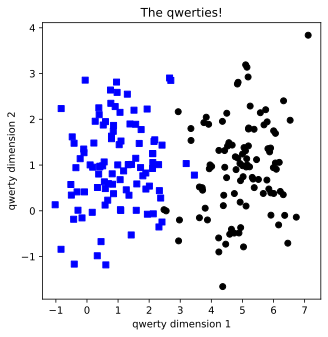

In [123]:
# create X

np.random.seed(708)

nPerClust = 100
blur = 1

A = [  1, 1 ]
B = [  5, 1 ]

# generate X
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true y
y_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
X_np = np.hstack((a,b)).T

# convert to a pytorch tensor
X = torch.tensor(X_np).float()
y = torch.tensor(y_np).float()

# show the X
fig = plt.figure(figsize=(5,5))
plt.plot(X[np.where(y==0)[0],0],X[np.where(y==0)[0],1],'bs')
plt.plot(X[np.where(y==1)[0],0],X[np.where(y==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [124]:
# inspect types
print(type(X_np))
print(np.shape(X_np))
print(' ')

print(type(X))
print(np.shape(X))

<class 'numpy.ndarray'>
(200, 2)
 
<class 'torch.Tensor'>
torch.Size([200, 2])


In [165]:
def classifier(X, y, hidden_layer_size, learning_rate, epochs):

    ANN = nn.Sequential(
        nn.Linear(2, hidden_layer_size),
        nn.ReLU(),
        nn.Linear(hidden_layer_size, 1),
        # nn.Sigmoid()
    )

    bce = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(ANN.parameters(), learning_rate)
    losses = torch.zeros(epochs)

    for epoch in range(epochs):
        _y_pred = ANN(X)
        _loss = bce(_y_pred, y)
        losses[epoch] = _loss
        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

    return ANN, losses

In [173]:
# param
HIDDEN_LAYER_SIZE = 2
LEARNING_RATE = 0.01
EPOCHES = 500

In [174]:
#train
model, losses = classifier(X=X, y=y, hidden_layer_size=HIDDEN_LAYER_SIZE, learning_rate=LEARNING_RATE, epochs=EPOCHES)

In [175]:
#predict
y_pred = model(X)

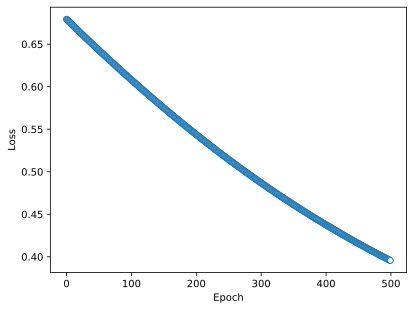

In [176]:
# show the losses

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [177]:
y_target = y_pred>.5

# find errors
misclassified = np.where(y_target != y)[0]

# total accuracy
totalacc = 100-100*len(misclassified)/(2*nPerClust)

print('Final accuracy: %g%%' %totalacc)

Final accuracy: 95.5%


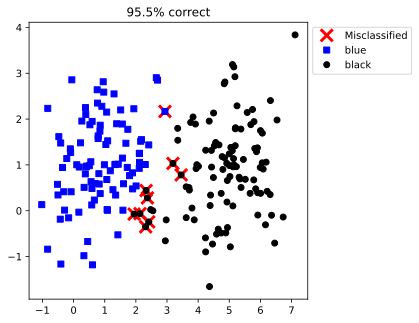

In [178]:
# plot the labeled X
fig = plt.figure(figsize=(5,5))
plt.plot(X[misclassified,0] ,X[misclassified,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(X[np.where(~y_target)[0],0],X[np.where(~y_target)[0],1],'bs')
plt.plot(X[np.where(y_target)[0],0] ,X[np.where(y_target)[0],1] ,'ko')

plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1))
plt.title(f'{totalacc}% correct')
plt.show()

## Learning Rate


In [179]:
# param
HIDDEN_LAYER_SIZE = 2

In [181]:
# -------- 函数：计算准确率 --------
def compute_accuracy(y_pred, y_true):
    preds = (y_pred > 0.5).float()
    correct = (preds == y_true).float()
    return correct.mean().item()

In [195]:
# -------- 准备：定义学习率列表、容器 --------
learningrates = np.linspace(0.001, 0.1, 500)
epochs = 1000

accByLR = np.zeros(len(learningrates))
allLosses = torch.zeros(len(learningrates), epochs)

In [196]:
# -------- 主循环：针对每个 learning rate 训练模型 --------
for i, lr in enumerate(learningrates):
    model_, losses = classifier(X, y, HIDDEN_LAYER_SIZE, learning_rate=lr, epochs=epochs)
    y_pred = model_(X)

    accByLR[i] = compute_accuracy(y_pred, y)
    allLosses[i, :] = losses  # 注意 losses 是 tensor

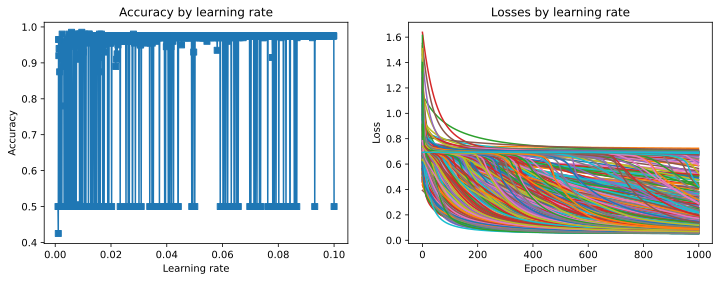

In [197]:
# -------- 可视化结果：两张图 --------
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# accuracy vs learning rate
ax[0].plot(learningrates, accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

# loss 曲线
ax[1].plot(allLosses.detach().T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')

plt.show()

#### meta experiment

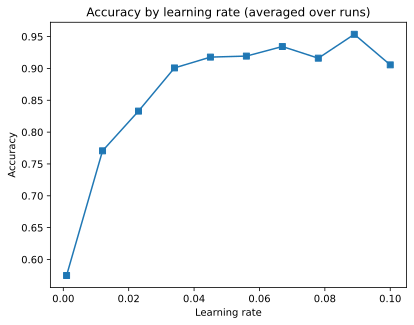

In [185]:
# run a "meta-experiment" by repeating the experiment N times
# (different random weight initializations each time)

# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps, len(learningrates)))

# fewer epochs to reduce computation time
numepochs = 500

for expi in range(numExps):
    for i, lr in enumerate(learningrates):
        
        # 用你自己的函数训练模型
        model_, _ = classifier(X, y, hidden_layer_size=HIDDEN_LAYER_SIZE, learning_rate=lr, epochs=numepochs)
        y_pred = model_(X)
        
        # 用你自己的 accuracy 函数
        acc = compute_accuracy(y_pred, y)

        # 存储结果
        accMeta[expi, i] = acc

# now plot the results, averaged over experiments
plt.plot(learningrates, np.mean(accMeta, axis=0), 's-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate (averaged over runs)')
plt.show()
